In [166]:
# DATA2001 Week 9 Tutorial
# Material last updated: 26 Apr 2023
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Week 9 - Spatial Data

This week's tutorial extends beyond the world of simple data types and into the realm of **geo-spatial data**. Today we'll be covering the basic types, how to ingest it from different sources (shape files, geoJSON, web APIs) and then querying it in PostGIS - a spatial database extension for PostgreSQL.

## 1. Introduction to Spatial Data

While geospatial data can exist in many forms (e.g. just 'latitude' and 'longitude' fields technically constitute spatial information), the **shapefile** is the most common data format for geographic information. It is a complex format, often involving multiple files. We've provided a simple "world" shapefile containing basic shapes of most international countries, which contains the following files:

| file | purpose |
| :--- | :--- |
| world.shp | the feature geometry itself |
| world.shx | positional indexes to speed things up |
| world.dbf | the other attributes |

These are just some of many other files that together can comprise a shapefile - see the [wiki](https://en.wikipedia.org/wiki/Shapefile) for more information.

### 1.1 Shapefiles and Polygons

Firstly, we'll have to leverage a couple new packages.
- Pandas has an extension named **GeoPandas**, intended for querying spatial data
- **Shapely** is a crucial package for interpreting and manipulating geometries
- **Geoalchemy** is a support library for SQLAlchemy (which we've used before), allowing spatial databases

Install these as per usual in your command line window (e.g. `pip3 install geopandas`).

In [167]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

Loading in the shapefile is quite simple when done through GeoPandas, working much like Pandas reads in CSVs.

Note the cell below assumes the `data.zip` has been downloaded from Canvas, and unpacked in the same directory as this notebook (i.e. there exists a 'data' folder containing the shapefile folders).

Note that the types in the geometry column are **polygons** and **multipolygons**. These reference full shapes - other simpler spatial data types include lines, points, etc. See the [ArcGIS docs](https://help.arcgis.com/en/geodatabase/10.0/sdk/arcsde/concepts/geometry/shapes/types.htm) for more.

In [168]:
countries = gpd.read_file("world/world.shp")
countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,12799293.0,Africa,Angola,AGO,110300.0,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59025 41.85540, 20.46318 41.51509..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,40913584.0,South America,Argentina,ARG,573900.0,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."
...,...,...,...,...,...,...
172,218519.0,Oceania,Vanuatu,VUT,988.5,"MULTIPOLYGON (((167.84488 -16.46633, 167.51518..."
173,23822783.0,Asia,Yemen,YEM,55280.0,"POLYGON ((53.10857 16.65105, 52.38521 16.38241..."
174,49052489.0,Africa,South Africa,ZAF,491000.0,"POLYGON ((31.52100 -29.25739, 31.32556 -29.401..."
175,11862740.0,Africa,Zambia,ZMB,17500.0,"POLYGON ((32.75938 -9.23060, 33.23139 -9.67672..."


#### How many countries are there?

A dataset like this is the perfect segue to a data quality discussion, and the semantics of definitions. While some countries are clearly missing, what would be considered a **complete** dataframe here? For those interested, [this video](https://www.youtube.com/watch?v=4AivEQmfPpk) unpacks how difficult it is to answer the true number of countries (the most wholesome example is probably Kosovo, who aren't universally recognised as an independent country, and have a [website](https://www.kosovothanksyou.com/) to thank those who consider it a legitimate state!)

### 1.2 Geopandas Transformations

Another dataset provided on Canvas contains capital cities across the world, provided by [SimpleMaps](https://simplemaps.com/data/world-cities). This is a simple CSV, containing the latitude and longitude coordinates of each city, as well as a population estimate, and the type of capital it is.

In [169]:
cities = pd.read_csv('Capitals.csv')
cities

,city,lat,lng,population,capital
0,Tokyo,35.6839,139.7744,39105000.0,primary
1,Jakarta,-6.2146,106.8451,35362000.0,primary
2,Delhi,28.6667,77.2167,31870000.0,admin
3,Manila,14.6000,120.9833,23971000.0,primary
4,Sao Paulo,-23.5504,-46.6339,22495000.0,admin
...,...,...,...,...,...
9807,Greytown,10.9167,-83.7000,275.0,minor
9808,La Esmeralda,3.1738,-65.5466,150.0,minor
9809,Hodrogo,48.9664,96.7833,10.0,minor
9810,Charlotte Amalie,18.3419,-64.9332,NaN,primary


We can leverage GeoPandas' `.points_from_xy()` function to properly store a geographical point.

In [170]:
cities['geom'] = gpd.points_from_xy(cities.lng, cities.lat)  # creating the geometry column
cities = cities.drop(columns=['lat', 'lng'])  # removing the old latitude/longitude fields
cities

,city,population,capital,geom
0,Tokyo,39105000.0,primary,POINT (139.77440 35.68390)
1,Jakarta,35362000.0,primary,POINT (106.84510 -6.21460)
2,Delhi,31870000.0,admin,POINT (77.21670 28.66670)
3,Manila,23971000.0,primary,POINT (120.98330 14.60000)
4,Sao Paulo,22495000.0,admin,POINT (-46.63390 -23.55040)
...,...,...,...,...
9807,Greytown,275.0,minor,POINT (-83.70000 10.91670)
9808,La Esmeralda,150.0,minor,POINT (-65.54660 3.17380)
9809,Hodrogo,10.0,minor,POINT (96.78330 48.96640)
9810,Charlotte Amalie,NaN,primary,POINT (-64.93320 18.34190)


## 2. Loading Spatial Data

Loading the information into Pandas dataframes is a useful start, but to begin forming queries, we must ingest the data into our SQL databases.

### 2.1 Requirements

The below functions are taken directly from the Week 4 tutorial. Remember this requires a `Credentials.json` file to exist in the same directory as this notebook, as was needed in previous weeks.

In [171]:
from sqlalchemy import text

In [172]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(text(sqlcmd), conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

The below cell actually connects to the database - should you reach errors, check your credentials file, ensure you're using the VPN, and consult the [FAQ thread on Ed](https://edstem.org/au/courses/8139/discussion/769731).

In [173]:
db, conn = pgconnect(credentials)

Connected successfully.


Note the functions we'll be leveraging for geographical operations rely on PostGIS (the spatial extension to PostgreSQL) being installed on the database - the below query confirms it is correctly configured.

In [174]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### 2.2 SRID Transformations

Ensuring the spatial data types from GeoPandas are the same as those expected by PostGIS requires conversion to the **Well-Known Text (WKT)** format, as an intermediate step. This can be done using the `geoalchemy2` library, to convert from the `shapely` types in GeoPandas to the WKT format in PostGIS.

We'll also be sure to specify the **Spatial Reference Identifier (SRID)** - in this case 4326, to represent the [WGS84 world geodetic coordinate system](https://en.wikipedia.org/wiki/World_Geodetic_System) used by our example data set. The following code simply converts the 'geom' column of the **Cities** dataframe accordingly.

In [175]:
srid = 4326
cities['geom'] = cities['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
cities 

,city,population,capital,geom
0,Tokyo,39105000.0,primary,POINT (139.7744 35.6839)
1,Jakarta,35362000.0,primary,POINT (106.8451 -6.2146)
2,Delhi,31870000.0,admin,POINT (77.2167 28.6667)
3,Manila,23971000.0,primary,POINT (120.9833 14.6)
4,Sao Paulo,22495000.0,admin,POINT (-46.6339 -23.5504)
...,...,...,...,...
9807,Greytown,275.0,minor,POINT (-83.7 10.9167)
9808,La Esmeralda,150.0,minor,POINT (-65.5466 3.1738)
9809,Hodrogo,10.0,minor,POINT (96.7833 48.9664)
9810,Charlotte Amalie,NaN,primary,POINT (-64.9332 18.3419)


Converting the polygons in our **Countries** dataframe requires more work. We'll first ensure they're all represented as multipolygons (of which polygons are a subset), and then conduct the same WKT conversion, all using a simple helper function.

In [176]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

countriesog = countries.copy()  # creating a copy of the original for later
countries['geom'] = countries['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
countries = countries.drop(columns="geometry")  # deleting the old copy
countries

,pop_est,continent,name,iso_a3,gdp_md_est,geom
0,28400000.0,Asia,Afghanistan,AFG,22270.0,MULTIPOLYGON (((61.210817091725744 35.65007233...
1,12799293.0,Africa,Angola,AGO,110300.0,MULTIPOLYGON (((16.326528354567046 -5.87747039...
2,3639453.0,Europe,Albania,ALB,21810.0,MULTIPOLYGON (((20.59024743010491 41.855404161...
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,MULTIPOLYGON (((51.57951867046327 24.245497137...
4,40913584.0,South America,Argentina,ARG,573900.0,MULTIPOLYGON (((-65.50000000000003 -55.1999999...
...,...,...,...,...,...,...
172,218519.0,Oceania,Vanuatu,VUT,988.5,MULTIPOLYGON (((167.8448767438451 -16.46633310...
173,23822783.0,Asia,Yemen,YEM,55280.0,MULTIPOLYGON (((53.10857262554751 16.651051133...
174,49052489.0,Africa,South Africa,ZAF,491000.0,MULTIPOLYGON (((31.521001417778876 -29.2573869...
175,11862740.0,Africa,Zambia,ZMB,17500.0,MULTIPOLYGON (((32.75937544122132 -9.230599053...


### 2.3 Ingestion

Let's proceed to populate tables in our database, firstly by defining schemas for each. Note the SRID is referenced in the geometry columns.

In [177]:
conn.execute(text("""
DROP TABLE IF EXISTS cities;
CREATE TABLE cities (
    city VARCHAR(100), 
    population INTEGER, 
    capital VARCHAR(10),
    geom GEOMETRY(POINT,4326)
);"""
))

conn.execute(text("""
DROP TABLE IF EXISTS world;
CREATE TABLE world (
    pop_est NUMERIC, 
    continent VARCHAR(80), 
    name VARCHAR(80), 
    iso_a3 VARCHAR(80), 
    gdp_md_est NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""))

With this established, we can insert the data into these tables. With spatial data, it does require our code to be explicit in our type defintions so the `geoalchemy` library can handle the conversions.

Firstly, we'll test the **Cities** table (will take longer than Countries due to the containing many more rows), then the **Countries** information.

In [178]:
cities.to_sql('cities', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from cities")

,city,population,capital,geom
0,Tokyo,39105000.0,primary,0101000020E6100000B84082E2C778614001DE02098AD7...
1,Jakarta,35362000.0,primary,0101000020E610000060764F1E16B65A40EBE2361AC0DB...
2,Delhi,31870000.0,admin,0101000020E6100000C442AD69DE4D5340423EE8D9ACAA...
3,Manila,23971000.0,primary,0101000020E6100000098A1F63EE3E5E40333333333333...
4,Sao Paulo,22495000.0,admin,0101000020E61000009A779CA2235147C0E9B7AF03E78C...
...,...,...,...,...
9807,Greytown,275.0,minor,0101000020E6100000CDCCCCCCCCEC54C0857CD0B359D5...
9808,La Esmeralda,150.0,minor,0101000020E610000097FF907EFB6250C0C05B2041F163...
9809,Hodrogo,10.0,minor,0101000020E61000003CBD5296213258405D6DC5FEB27B...
9810,Charlotte Amalie,NaN,primary,0101000020E610000024287E8CB93B50C09D8026C28657...


In [179]:
countries.to_sql("world", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from world")

,pop_est,continent,name,iso_a3,gdp_md_est,geom
0,28400000.0,Asia,Afghanistan,AFG,22270.0,0106000020E61000000100000001030000000100000045...
1,12799293.0,Africa,Angola,AGO,110300.0,0106000020E61000000200000001030000000100000042...
2,3639453.0,Europe,Albania,ALB,21810.0,0106000020E61000000100000001030000000100000016...
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,0106000020E61000000100000001030000000100000016...
4,40913584.0,South America,Argentina,ARG,573900.0,0106000020E6100000020000000103000000010000000B...
...,...,...,...,...,...,...
172,218519.0,Oceania,Vanuatu,VUT,988.5,0106000020E61000000200000001030000000100000005...
173,23822783.0,Asia,Yemen,YEM,55280.0,0106000020E6100000010000000103000000010000002C...
174,49052489.0,Africa,South Africa,ZAF,491000.0,0106000020E61000000100000001030000000200000052...
175,11862740.0,Africa,Zambia,ZMB,17500.0,0106000020E6100000010000000103000000010000003D...


## 3. Querying Spatial Data

With the data now populated, we can commence with the interesting part - building queries and answering questions!

### 3.1 Areas

Let's walk through an example, by calculating the area of each region. This can be achieved using the PostGIS `ST_Area()` function. Below would therefore be a query that returns the **five largest countries in Africa**.

In [180]:
sql = """
SELECT name AS country, ST_Area(geom) AS total_area
FROM world
WHERE continent='Africa'
ORDER BY total_area DESC
LIMIT 5
"""
query(conn, sql)

,country,total_area
0,Algeria,213.602772
1,Dem. Rep. Congo,189.515232
2,Sudan,156.444543
3,Libya,148.853147
4,South Africa,112.718524


Now there is a small catch with area calculations, which is alluded to by the low numbers returned (these reflect the geometry type and selected SRID). 

In order to get the size in square meters ($m^2$), we need use the **geography** type which treats polygons not as objects on a flat plane, but on a sphere, which makes them suitable for geodetic data like these world maps here. We can convert the geometries to the the GEOGRAPHY type by using `::geography` as a cast operator:

In [181]:
sql = """
SELECT name AS country, ST_Area(geom::geography) AS total_area_m2
FROM world
WHERE continent='Africa'
ORDER BY total_area_m2 DESC
LIMIT 5
"""
query(conn, sql)

,country,total_area_m2
0,Dem. Rep. Congo,2.323492e+12
1,Algeria,2.315917e+12
2,Sudan,1.850886e+12
3,Libya,1.633721e+12
4,Chad,1.271695e+12


Final minor addition if scientific notation isn't ideal - we can express this as a complete integer using a basic Pandas transformation.

In [182]:
results = query(conn, sql)
results['total_area_m2'] = results['total_area_m2'].astype('int64')
results

,country,total_area_m2
0,Dem. Rep. Congo,2323492477513
1,Algeria,2315916657885
2,Sudan,1850886093214
3,Libya,1633720717372
4,Chad,1271694598203


### 3.2 Points

Let's consider another spatial function - `ST_Contains()`. This can be used to determine if a given point lies within a region.

According to Google, the coordinates of Paris are `48.8566° N, 2.3522° E`. If we store this as a geometric point (using `ST_Point` - note the longitude comes first!) and then convert this into the SRID using `ST_SetSRID()` function, we can then see if any of the polygons in our countries dataframe contain this point. As expected, this should yield France:

In [183]:
sql = """
SELECT name
FROM world
WHERE ST_Contains(geom, ST_SetSRID(ST_Point(2.3, 48.86), 4326))
"""
query(conn, sql)

,name
0,France


**a) Find all cities within Australia**

Hint: this involves using the ST functions as the *join* condition. As an extension, see if it can be achieved with multiple different spatial functions (see the [PostGIS docs for more functions](https://postgis.net/docs/reference.html)).

In [184]:
sql = """
SELECT *
from world
limit 10
"""
query(conn, sql)

,pop_est,continent,name,iso_a3,gdp_md_est,geom
0,28400000.0,Asia,Afghanistan,AFG,22270.0,0106000020E61000000100000001030000000100000045...
1,12799293.0,Africa,Angola,AGO,110300.0,0106000020E61000000200000001030000000100000042...
2,3639453.0,Europe,Albania,ALB,21810.0,0106000020E61000000100000001030000000100000016...
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,0106000020E61000000100000001030000000100000016...
4,40913584.0,South America,Argentina,ARG,573900.0,0106000020E6100000020000000103000000010000000B...
5,2967004.0,Asia,Armenia,ARM,18770.0,0106000020E61000000100000001030000000100000014...
6,3802.0,Antarctica,Antarctica,ATA,760.4,0106000020E6100000080000000103000000010000000D...
7,140.0,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16.0,0106000020E61000000100000001030000000100000009...
8,7204687.0,Europe,Bulgaria,BGR,93750.0,0106000020E6100000010000000103000000010000001C...
9,309156.0,North America,Bahamas,BHS,9093.0,0106000020E61000000300000001030000000100000008...


In [185]:
sql = """
SELECT *
from cities
where city = 'Canberra'
"""
query(conn, sql)

,city,population,capital,geom
0,Canberra,381488,primary,0101000020E610000099BB96900FA46240933A014D84A5...


In [186]:
## TO DO
sql = """
SELECT DISTINCT(C.city), W.name
FROM Cities C join World W on (ST_contains(W.geom, C.geom))
where W.name = 'Italy' and C.capital = 'primary'
"""
query(conn, sql)

,city,name
0,Rome,Italy
1,San Marino,Italy
2,Vatican City,Italy


**b) List all countries that have more than two primary capital cities.**

Which appears to have the most? Is this accurate? Why or why not?

In [187]:
## TO DO
sql = """
SELECT W.name, COUNT(C.capital)
FROM Cities C join World W on (ST_contains(W.geom, C.geom))
where C.capital = 'primary'
group by W.name
having COUNT(C.capital) >= 2
order by COUNT(C.capital) DESC
"""
query(conn, sql)

,name,count
0,France,4
1,Italy,3
2,South Africa,3
3,Burundi,2
4,China,2
5,Côte d'Ivoire,2
6,Dem. Rep. Congo,2
7,Malaysia,2
8,Myanmar,2
9,Netherlands,2


### 3.3 Intersections

Returning to our example of Kosovo earlier, let's see if we can determine it's neighbouring countries.

We can leverage a **self-join** with the 'world' table to determine which countries share a boundary with each other. Normally, we would expect to use the `ST_Touch()` function for this, but in our dataset, the boundaries are in low-resolution, so some border shapes actually intersect. Hence the more generic `ST_Intersects()` spatial relationship function should suffice.

In [188]:
sql = """
SELECT B.name
FROM world A JOIN world B ON ST_Intersects(A.geom, B.geom)
WHERE A.name = 'Kosovo' AND B.name != A.name
"""
query(conn, sql)

,name
0,Albania
1,Macedonia
2,Montenegro
3,Serbia


**a) Find all countries that neighbour Germany, ordered by the furthest north neighbour to the nearest south.**

Ordering successfully will require the y-value of the centre point of a given polygon - try finding [spatial functions](https://postgis.net/docs/reference.html) to achieve this!

In [194]:
## TO DO
sql = """
SELECT B.name
FROM world A JOIN world B ON ST_Intersects(A.geom, B.geom)
WHERE A.name = 'Germany' AND B.name != A.name
ORDER BY ST_Y(ST_Centroid(B.geom)) DESC
"""
query(conn, sql)

,name
0,Denmark
1,Netherlands
2,Poland
3,Belgium
4,Czech Rep.
5,Luxembourg
6,Austria
7,Switzerland
8,France


**b) Find the most common city name in the dataset. Afterwards, determine which countries these cities exist in.**

There are 4 'San Luis' cities - 2 in Cuba, 1 in Argentina, and 1 in Guatemala. Are any city names more common, and what countries are they found in?

Spoiler: you can confirm your answer using [this Wikipedia page](https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Colombia).

In [190]:
## TO DO - QUERY 1
sql = """
SELECT C.city, W.name
FROM City C join World W on (C.=)
"""
query(conn, sql)

Error encountered: 
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: 

]
(Background on this error at: https://sqlalche.me/e/20/f405)


""


In [191]:
## TO DO - QUERY 2
sql = """

"""
query(conn, sql)

Error encountered: 
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: 

]
(Background on this error at: https://sqlalche.me/e/20/f405)


""


## 4. Maps

Another beautiful application of spatial data involves plotting the results. No tasks here - just a brief demonstration. The below code filters the original version of the **Countries** dataframe to only countries within Europe and Asia, and then plots them using `matplotlib`.

<AxesSubplot:>

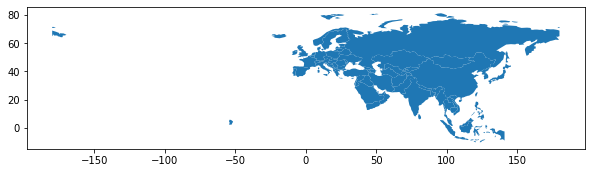

In [192]:
eurasia = countriesog[(countriesog['continent']=='Europe') | (countriesog['continent']=='Asia')]
eurasia.plot(figsize=(10, 10))

We can achieve the same result with a combination of SQL and GeoPandas.

In [193]:
eurasia = gpd.read_postgis("SELECT name, geom FROM world WHERE continent='Europe' or continent='Asia'", conn)
eurasia.plot(figsize=(10, 10))

ObjectNotExecutableError: Not an executable object: "SELECT name, geom FROM world WHERE continent='Europe' or continent='Asia'"

For an even more aesthetic result - we can add a colour palette.

In [ ]:
eurasia.plot(cmap='Set2', figsize=(10, 10))

And when complete, we can export geospatial subsets as new shapefiles. The following code will create a new 'Eurasia' shapefile.

In [ ]:
eurasia.to_file("world/eurasia.shp")

### 4.2 API

Week 7's tutorial investigated APIs. One example included using the **OpenStreetMap API** to return details of locations. One of the functionalities offered by this platform that we didn't fully explore was the ability to extract the corresponding geospatial polygons. Let's first return to the code block we used to access the API:

In [ ]:
import time as t
import requests
def address_details(params, wait=5):
    base_url = 'https://nominatim.openstreetmap.org/search'
    t.sleep(wait)  # 5 second wait to avoid overloading (too many requests could lock out the whole uni's IP range!)
    response = requests.get(base_url, params = params)
    return response.json()

Let's again search for the School of Computer Science, found at 1 Cleveland Street, Darlington. An additional parameter we'll pass is setting `polygon_geojson` to 1, which will return us the coordinates of it's boundaries, as seen below:

In [ ]:
parameters = {'q': '1 Cleveland Street, Darlington, Australia', 'limit':'1', 'format': 'json', 'polygon_geojson': '1'}
results = address_details(parameters)
print(results[0]['geojson']['coordinates'])

A couple dozen coordinates printed out isn't particularly inspiring. Seeing it plotted though, is quite beautiful. Compare the output below to the shape of the building on Google Maps - it's quite a good match!

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))  # setting up the plot
ax.ticklabel_format(useOffset=False)  # avoiding scientific notation on the axes
p = Polygon(results[0]['geojson']['coordinates'][0])  # taking the coordinates returned and storing them as a polygon
x,y = p.exterior.xy  # extracting the x and y coordinates from the exterior of that polygon
ax.plot(x,y)  # plotting them on the graph
plt.title("School of Computer Science", fontdict={'fontsize': 16}, pad=10)  # setting a title
plt.xlabel("Longitude", fontdict={'fontsize': 14}, labelpad=10)  # setting an x-axis
plt.ylabel("Latitude", fontdict={'fontsize': 14}, labelpad=10)  # setting a y-axis
plt.show()  # displaying the plot

#### Tutorial Complete!

Hopefully this was a useful introduction to geospatial data, which will be crucial to the group assignment. Remember to close your database connections, and enjoy your week!

In [ ]:
conn.close()
db.dispose()